# Don't Unfold!!!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.chdir('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import sys
sys.path.append("Marigold")

import jhutil; jhutil.color_log(1111, )

 1111 


In [2]:
os.environ['BASE_DATA_DIR'] = '/root/wlsgur4011/marigold_data'
os.environ['BASE_CKPT_DIR'] = '/data2/wlsgur4011/Marigold/checkpoint'

In [3]:
import sys
sys.argv = ["train.py", "--config", "config/train_marigold.yaml", "--no_wandb", "--three_modality"]

In [4]:

import argparse
import logging
import os
import shutil
from datetime import datetime, timedelta
from typing import List

import torch
from omegaconf import OmegaConf
from torch.utils.data import ConcatDataset, DataLoader
from tqdm import tqdm
from marigold.marigold_pipeline import MarigoldPipeline
from src.dataset import BaseDepthDataset, DatasetMode, get_dataset
from src.dataset.mixed_sampler import MixedBatchSampler
from src.trainer import get_trainer_cls
from src.util.config_util import (
    find_value_in_omegaconf,
    recursive_load_config,
)
from src.util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)
from src.util.logging_util import (
    config_logging,
    init_wandb,
    load_wandb_job_id,
    log_slurm_job_id,
    save_wandb_job_id,
    tb_logger,
)
from src.util.slurm_util import get_local_scratch_dir, is_on_slurm

if "__main__" == __name__:
    t_start = datetime.now()
    print(f"start at {t_start}")

    # -------------------- Arguments --------------------
    parser = argparse.ArgumentParser(description="Train your cute model!")
    parser.add_argument(
        "--config",
        type=str,
        default="config/train_marigold.yaml",
        help="Path to config file.",
    )
    parser.add_argument(
        "--resume_run",
        action="store",
        default=None,
        help="Path of checkpoint to be resumed. If given, will ignore --config, and checkpoint in the config",
    )
    parser.add_argument(
        "--output_dir", type=str, default=None, help="directory to save checkpoints"
    )
    parser.add_argument("--no_cuda", action="store_true", help="Do not use cuda.")
    parser.add_argument(
        "--exit_after",
        type=int,
        default=-1,
        help="Save checkpoint and exit after X minutes.",
    )
    parser.add_argument("--no_wandb", action="store_true", help="run without wandb")
    parser.add_argument(
        "--do_not_copy_data",
        action="store_true",
        help="On Slurm cluster, do not copy data to local scratch",
    )
    parser.add_argument(
        "--base_data_dir", type=str, default=None, help="directory of training data"
    )
    parser.add_argument(
        "--base_ckpt_dir",
        type=str,
        default=None,
        help="directory of pretrained checkpoint",
    )
    parser.add_argument(
        "--add_datetime_prefix",
        action="store_true",
        help="Add datetime to the output folder name",
    )
    parser.add_argument("--three_modality", action="store_true")

    args = parser.parse_args()
    resume_run = args.resume_run
    output_dir = args.output_dir
    base_data_dir = (
        args.base_data_dir
        if args.base_data_dir is not None
        else os.environ["BASE_DATA_DIR"]
    )
    base_ckpt_dir = (
        args.base_ckpt_dir
        if args.base_ckpt_dir is not None
        else os.environ["BASE_CKPT_DIR"]
    )

    # -------------------- Initialization --------------------
    # Resume previous run
    if resume_run is not None:
        print(f"Resume run: {resume_run}")
        out_dir_run = os.path.dirname(os.path.dirname(resume_run))
        job_name = os.path.basename(out_dir_run)
        # Resume config file
        cfg = OmegaConf.load(os.path.join(out_dir_run, "config.yaml"))
    else:
        # Run from start
        cfg = recursive_load_config(args.config)
        # Full job name
        pure_job_name = os.path.basename(args.config).split(".")[0]
        # Add time prefix
        if args.add_datetime_prefix:
            job_name = f"{t_start.strftime('%y_%m_%d-%H_%M_%S')}-{pure_job_name}"
        else:
            job_name = pure_job_name

        # Output dir
        if output_dir is not None:
            out_dir_run = os.path.join(output_dir, job_name)
        else:
            out_dir_run = os.path.join("./output", job_name)
        os.makedirs(out_dir_run, exist_ok=True)

    if args.three_modality:
        cfg.dataloader.max_train_batch_size = 1
    cfg_data = cfg.dataset

    # Other directories
    out_dir_ckpt = os.path.join(out_dir_run, "checkpoint")
    if not os.path.exists(out_dir_ckpt):
        os.makedirs(out_dir_ckpt)
    out_dir_tb = os.path.join(out_dir_run, "tensorboard")
    if not os.path.exists(out_dir_tb):
        os.makedirs(out_dir_tb)
    out_dir_eval = os.path.join(out_dir_run, "evaluation")
    if not os.path.exists(out_dir_eval):
        os.makedirs(out_dir_eval)
    out_dir_vis = os.path.join(out_dir_run, "visualization")
    if not os.path.exists(out_dir_vis):
        os.makedirs(out_dir_vis)

    # -------------------- Logging settings --------------------
    config_logging(cfg.logging, out_dir=out_dir_run)
    logging.debug(f"config: {cfg}")

    # Initialize wandb
    if not args.no_wandb:
        if resume_run is not None:
            wandb_id = load_wandb_job_id(out_dir_run)
            wandb_cfg_dic = {
                "id": wandb_id,
                "resume": "must",
                **cfg.wandb,
            }
        else:
            wandb_cfg_dic = {
                "config": dict(cfg),
                "name": job_name,
                "mode": "online",
                **cfg.wandb,
            }
        wandb_cfg_dic.update({"dir": out_dir_run})
        wandb_run = init_wandb(enable=True, **wandb_cfg_dic)
        save_wandb_job_id(wandb_run, out_dir_run)
    else:
        init_wandb(enable=False)

    # Tensorboard (should be initialized after wandb)
    tb_logger.set_dir(out_dir_tb)

    log_slurm_job_id(step=0)

    # -------------------- Device --------------------
    cuda_avail = torch.cuda.is_available() and not args.no_cuda
    device = torch.device("cuda" if cuda_avail else "cpu")
    logging.info(f"device = {device}")

    # -------------------- Snapshot of code and config --------------------
    if resume_run is None:
        _output_path = os.path.join(out_dir_run, "config.yaml")
        with open(_output_path, "w+") as f:
            OmegaConf.save(config=cfg, f=f)
        logging.info(f"Config saved to {_output_path}")
        # Copy and tar code on the first run
        _temp_code_dir = os.path.join(out_dir_run, "code_tar")
        _code_snapshot_path = os.path.join(out_dir_run, "code_snapshot.tar")
        os.system(
            f"rsync --relative -arhvz --quiet --filter=':- .gitignore' --exclude '.git' . '{_temp_code_dir}'"
        )
        os.system(f"tar -cf {_code_snapshot_path} {_temp_code_dir}")
        os.system(f"rm -rf {_temp_code_dir}")
        logging.info(f"Code snapshot saved to: {_code_snapshot_path}")

    # -------------------- Copy data to local scratch (Slurm) --------------------
    if is_on_slurm() and (not args.do_not_copy_data):
        # local scratch dir
        original_data_dir = base_data_dir
        base_data_dir = os.path.join(get_local_scratch_dir(), "Marigold_data")
        # copy data
        required_data_list = find_value_in_omegaconf("dir", cfg_data)
        # if cfg_train.visualize.init_latent_path is not None:
        #     required_data_list.append(cfg_train.visualize.init_latent_path)
        required_data_list = list(set(required_data_list))
        logging.info(f"Required_data_list: {required_data_list}")
        for d in tqdm(required_data_list, desc="Copy data to local scratch"):
            ori_dir = os.path.join(original_data_dir, d)
            dst_dir = os.path.join(base_data_dir, d)
            os.makedirs(os.path.dirname(dst_dir), exist_ok=True)
            if os.path.isfile(ori_dir):
                shutil.copyfile(ori_dir, dst_dir)
            elif os.path.isdir(ori_dir):
                shutil.copytree(ori_dir, dst_dir)
        logging.info(f"Data copied to: {base_data_dir}")

    # -------------------- Gradient accumulation steps --------------------
    eff_bs = cfg.dataloader.effective_batch_size
    accumulation_steps = eff_bs / cfg.dataloader.max_train_batch_size
    assert int(accumulation_steps) == accumulation_steps
    accumulation_steps = int(accumulation_steps)

    logging.info(
        f"Effective batch size: {eff_bs}, accumulation steps: {accumulation_steps}"
    )

    # -------------------- Data --------------------
    loader_seed = cfg.dataloader.seed
    if loader_seed is None:
        loader_generator = None
    else:
        loader_generator = torch.Generator().manual_seed(loader_seed)

    # Training dataset
    depth_transform: DepthNormalizerBase = get_depth_normalizer(
        cfg_normalizer=cfg.depth_normalization
    )
    train_dataset: BaseDepthDataset = get_dataset(
        cfg_data.train,
        base_data_dir=base_data_dir,
        mode=DatasetMode.TRAIN,
        augmentation_args=cfg.augmentation,
        depth_transform=depth_transform,
    )
    if args.three_modality:
        from src.dataset import collate_fn_three_modality
        collate_fn = collate_fn_three_modality
    else:
        collate_fn = None
    
    logging.debug("Augmentation: ", cfg.augmentation)
    if "mixed" == cfg_data.train.name:
        dataset_ls = train_dataset
        assert len(cfg_data.train.prob_ls) == len(
            dataset_ls
        ), "Lengths don't match: `prob_ls` and `dataset_list`"
        concat_dataset = ConcatDataset(dataset_ls)
        mixed_sampler = MixedBatchSampler(
            src_dataset_ls=dataset_ls,
            batch_size=cfg.dataloader.max_train_batch_size,
            drop_last=True,
            prob=cfg_data.train.prob_ls,
            shuffle=True,
            generator=loader_generator,
        )
        train_loader = DataLoader(
            concat_dataset,
            batch_sampler=mixed_sampler,
            num_workers=cfg.dataloader.num_workers,
            collate_fn=collate_fn,
        )
    else:
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=cfg.dataloader.max_train_batch_size,
            num_workers=cfg.dataloader.num_workers,
            shuffle=True,
            generator=loader_generator,
            collate_fn=collate_fn,
        )
    # Validation dataset
    # val_loaders: List[DataLoader] = []
    # for _val_dic in cfg_data.val:
    #     _val_dataset = get_dataset(
    #         _val_dic,
    #         base_data_dir=base_data_dir,
    #         mode=DatasetMode.EVAL,
    #     )
    #     _val_loader = DataLoader(
    #         dataset=_val_dataset,
    #         batch_size=1,
    #         shuffle=False,
    #         num_workers=cfg.dataloader.num_workers,
    #     )
    #     val_loaders.append(_val_loader)

    # # Visualization dataset
    # vis_loaders: List[DataLoader] = []
    # for _vis_dic in cfg_data.vis:
    #     _vis_dataset = get_dataset(
    #         _vis_dic,
    #         base_data_dir=base_data_dir,
    #         mode=DatasetMode.EVAL,
    #     )
    #     _vis_loader = DataLoader(
    #         dataset=_vis_dataset,
    #         batch_size=1,
    #         shuffle=False,
    #         num_workers=cfg.dataloader.num_workers,
    #     )
    #     vis_loaders.append(_vis_loader)

    # -------------------- Model --------------------
    _pipeline_kwargs = cfg.pipeline.kwargs if cfg.pipeline.kwargs is not None else {}
    model = MarigoldPipeline.from_pretrained(
        os.path.join(base_ckpt_dir, cfg.model.pretrained_path), **_pipeline_kwargs
    )
    # -------------------- Trainer --------------------
    # Exit time
    if args.exit_after > 0:
        t_end = t_start + timedelta(minutes=args.exit_after)
        logging.info(f"Will exit at {t_end}")
    else:
        t_end = None

    trainer_cls = get_trainer_cls(cfg.trainer.name)
    logging.debug(f"Trainer: {trainer_cls}")
    trainer = trainer_cls(
        cfg=cfg,
        model=model,
        train_dataloader=train_loader,
        device=device,
        base_ckpt_dir=base_ckpt_dir,
        out_dir_ckpt=out_dir_ckpt,
        out_dir_eval=out_dir_eval,
        out_dir_vis=out_dir_vis,
        accumulation_steps=accumulation_steps,
        # val_dataloaders=val_loaders,
        # vis_dataloaders=vis_loaders,
        three_modality=args.three_modality,
    )

/opt/conda/envs/marigold/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


start at 2024-07-16 15:29:58.811939
 2024-07-16 15:29:58,927 - ERROR -jupyter.py - notebook_metadata >> Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
 2024-07-16 15:29:58,950 - INFO -2395782770.py - <module> >> device = cuda
 2024-07-16 15:29:58,964 - INFO -2395782770.py - <module> >> Config saved to ./output/train_marigold/config.yaml
 2024-07-16 15:29:59,148 - INFO -2395782770.py - <module> >> Code snapshot saved to: ./output/train_marigold/code_snapshot.tar
 2024-07-16 15:29:59,150 - INFO -2395782770.py - <module> >> Effective batch size: 32, accumulation steps: 32


/opt/conda/envs/marigold/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

 2024-07-16 15:30:00,235 - INFO -marigold_trainer.py - _replace_unet_conv_in >> Unet conv_in layer is replaced
 2024-07-16 15:30:00,237 - INFO -marigold_trainer.py - _replace_unet_conv_in >> Unet config is updated


# Data Visualize

In [20]:
for batch in train_loader:
    from jhutil import color_log; color_log(1111, batch)
    break

 1111  {
    "rgb_int": "tensor[3, 480, 640] i32 n=921600 (3.5Mb) x∈[5, 255] μ=140.288 σ=50.337",
    "rgb_norm": "tensor[3, 3, 480, 640] n=2764800 (11Mb) x∈[-0.961, 1.000] μ=0.100 σ=0.395",
    "depth_raw_linear": "tensor[1, 480, 640] n=307200 (1.2Mb) x∈[0.943, 57.302] μ=11.691 σ=19.175",
    "depth_filled_linear": "tensor[1, 480, 640] n=307200 (1.2Mb) x∈[0.943, 57.302] μ=11.691 σ=19.175",
    "valid_mask_raw": "tensor[3, 1, 480, 640] bool n=921600 (0.9Mb) x∈[True, True] μ=1.000 σ=0.",
    "valid_mask_filled": "tensor[1, 480, 640] bool n=307200 (0.3Mb) x∈[True, True] μ=1.000 σ=0.",
    "depth_raw_norm": "tensor[3, 1, 480, 640] n=921600 (3.5Mb) x∈[-1.000, 1.000] μ=-0.010 σ=0.840",
    "depth_filled_norm": "tensor[1, 480, 640] n=307200 (1.2Mb) x∈[-1.000, 1.000] μ=-0.610 σ=0.698",
    "index": 23467,
    "rgb_relative_path": "ai_027_001/rgb_cam_01_fr0044.png"
}


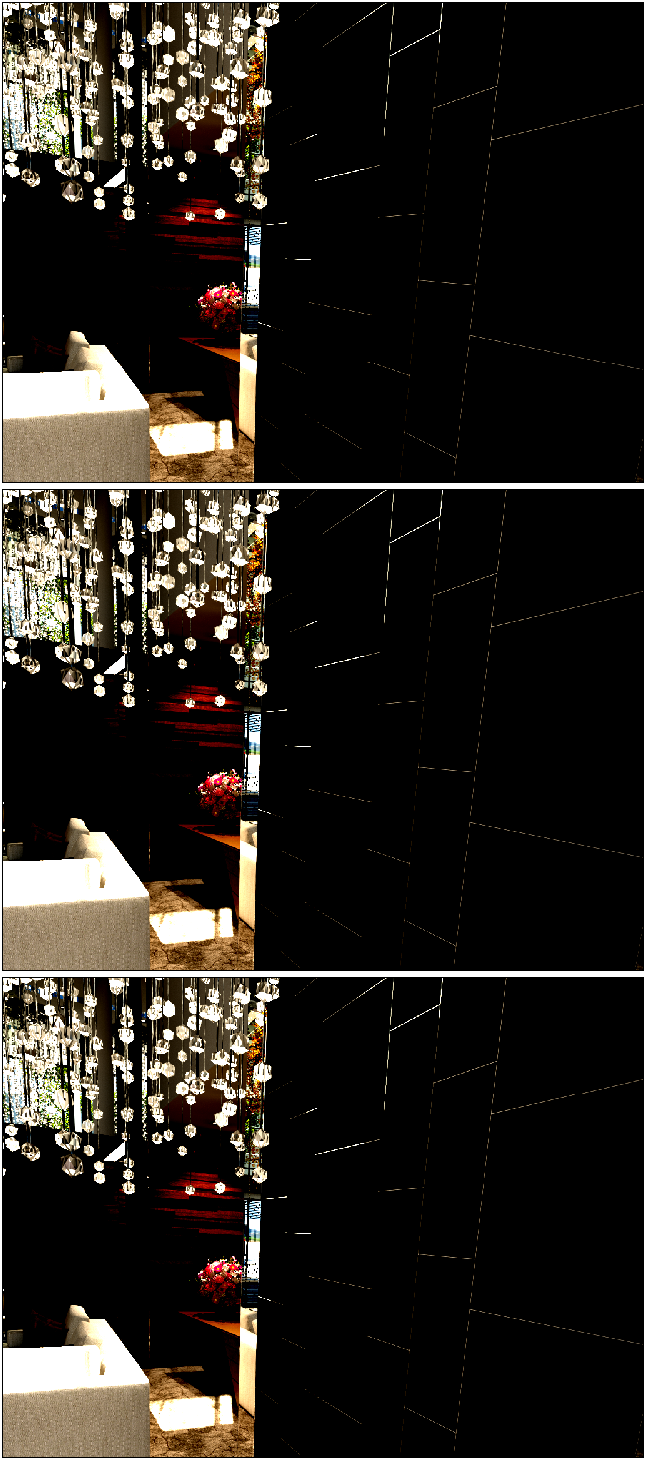

In [6]:
batch["rgb_norm"].rgb

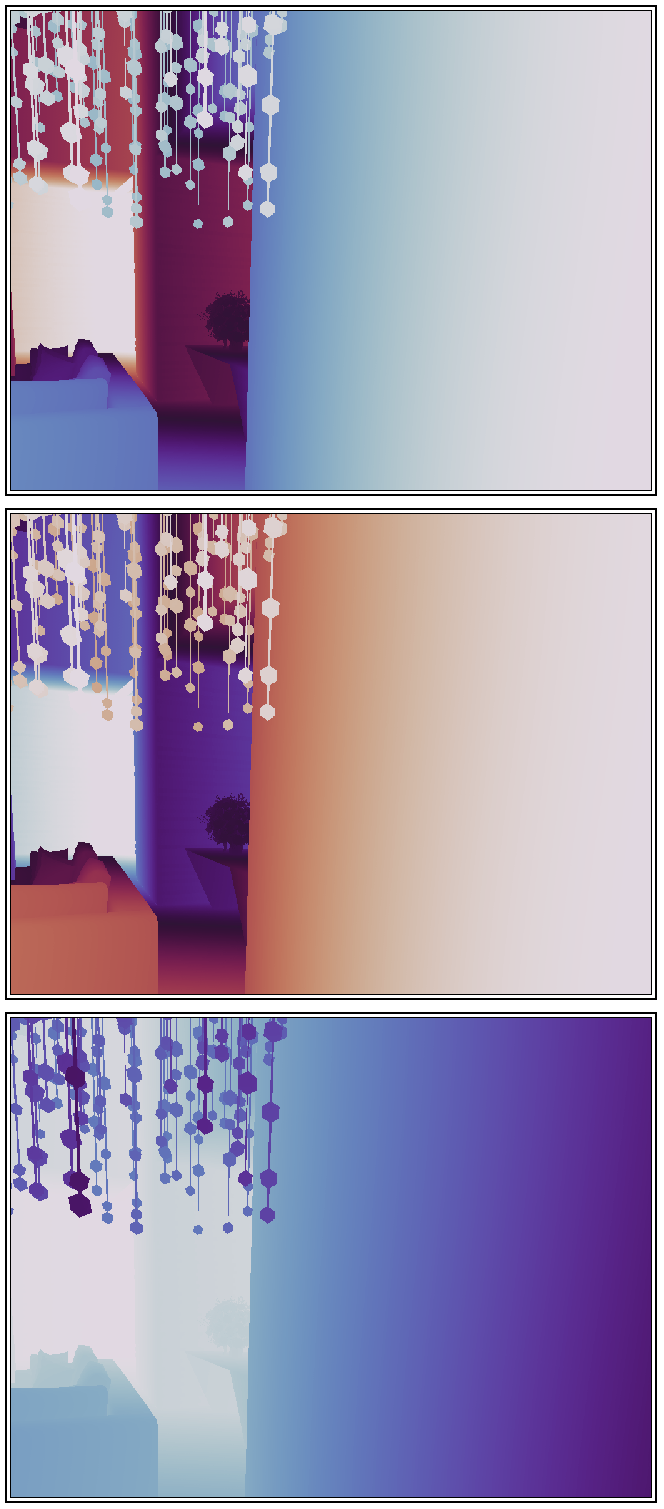

In [12]:
batch["depth_raw_norm"].chans